In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip "/content/drive/MyDrive/Cats and Dogs/test_set.zip"
# !unzip "/content/drive/MyDrive/Cats and Dogs/training_set.zip"

In [ ]:
import keras
from keras.layers import Dense, Dropout, MaxPool2D, Conv2D, Flatten, Concatenate, Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def inception_block(x,f):
  t1 = Conv2D(f[0],1,activation="relu")(x)
  
  t2 = Conv2D(f[1],1,activation="relu")(x)
  t2 = Conv2D(f[2],3,padding="same",activation="relu")(t2)
  
  t3 = Conv2D(f[3],1,activation="relu")(x)
  t3 = Conv2D(f[4],5,padding="same",activation="relu")(t3)

  t4 = MaxPool2D(3,1,padding="same")(x)
  t4 = Conv2D(f[5],1,activation="relu")(t4)

  output = Concatenate()([t1,t2,t3,t4])
  return output


In [ ]:
input = Input(shape = (224,224,3))
x = Conv2D(64, 7, strides = 2, padding = "same", activation = "relu")(input)
x = MaxPool2D(3, 2, padding="same")(x)
x = Conv2D(64, 1, activation = "relu")(x)
x = Conv2D(192, 3, padding="same", activation = "relu")(x)
x = MaxPool2D(3, 2, padding="same")(x)
x = inception_block(x, [64,96,128,16,32,32])

In [ ]:
# !unzip "/content/drive/MyDrive/Cats and Dogs/test_set.zip" -d "/content/drive/MyDrive/Cats and Dogs"
# !unzip "/content/drive/MyDrive/Cats and Dogs/training_set.zip" -d "/content/drive/MyDrive/Cats and Dogs"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_generator = ImageDataGenerator(rescale = 1/255, horizontal_flip = False, validation_split = 0.2)
test_generator = ImageDataGenerator(rescale = 1/255, horizontal_flip = False)

In [ ]:
train_path = "/content/drive/MyDrive/Cats and Dogs/training_set"
test_path = "/content/drive/MyDrive/Cats and Dogs/test_set"

train_dataset = train_generator.flow_from_directory(
    train_path,
    batch_size = 128,
    target_size = (224,224),
    class_mode = "binary",
    color_mode = "rgb",
    subset = "training"
)

validation_dataset = train_generator.flow_from_directory(
    train_path,
    batch_size = 128,
    target_size = (224,224),
    class_mode = "binary",
    color_mode = "rgb",
    subset = "validation"
)

test_dataset = train_generator.flow_from_directory(
    test_path,
    batch_size = 128,
    target_size = (224,224),
    class_mode = "binary",
    color_mode = "rgb",
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plt.imshow(train_dataset[0])
train_dataset[0][0].shape

(128, 224, 224, 3)

In [ ]:
from re import M
import os
myList = os.listdir(train_path)
print(myList)

['cats', 'dogs']


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3(input_shape = (224,224,3), weights = "imagenet", include_top = False)

In [ ]:
batch_size = 128
num_classes = 1


for layers in model.layers:
  layers.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512,activation="relu")(x)
prediction = Dense(num_classes,activation = "sigmoid")(x)
model = Model(model.input, prediction)
model.summary()
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_9[0][0]']               
 alization)                     )                                                             

In [ ]:
history = model.fit_generator(train_dataset, validation_data = validation_dataset, epochs = 3, shuffle = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/3
51/51 [==============================] - 65s 1s/step - loss: 0.1194 - accuracy: 0.9564 - val_loss: 0.0430 - val_accuracy: 0.9888
Epoch 2/3
51/51 [==============================] - 54s 1s/step - loss: 0.0281 - accuracy: 0.9895 - val_loss: 0.0336 - val_accuracy: 0.9894
Epoch 3/3
51/51 [==============================] - 51s 1000ms/step - loss: 0.0217 - accuracy: 0.9925 - val_loss: 0.0333 - val_accuracy: 0.9888


In [ ]:
model.evaluate_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.030479663982987404, 0.9911023378372192]

In [ ]:
# model.save("inception_model.h5")

In [ ]:
history = history.history

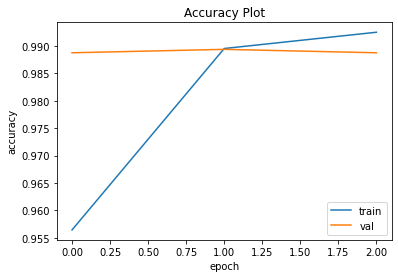

In [ ]:
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title("Accuracy Plot")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","val"])
plt.savefig("accuracy.png")

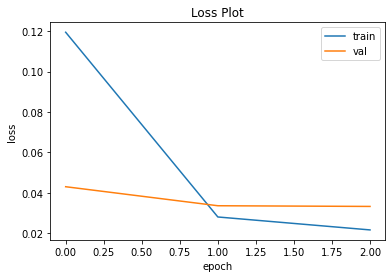

In [ ]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Loss Plot")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","val"])
plt.savefig("loss.png")

In [ ]:
!wget https://scx2.b-cdn.net/gfx/news/hires/2018/2-dog.jpg

--2022-03-02 05:36:11--  https://scx2.b-cdn.net/gfx/news/hires/2018/2-dog.jpg
Resolving scx2.b-cdn.net (scx2.b-cdn.net)... 185.93.1.243
Connecting to scx2.b-cdn.net (scx2.b-cdn.net)|185.93.1.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 415118 (405K) [image/jpeg]
Saving to: ‘2-dog.jpg.1’

2-dog.jpg.1         100%[===================>] 405.39K  --.-KB/s    in 0.04s   

2022-03-02 05:36:11 (9.03 MB/s) - ‘2-dog.jpg.1’ saved [415118/415118]



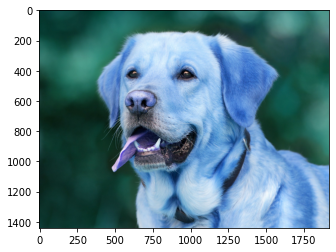

In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/content/2-dog.jpg')
image = cv2.resize(img, (224, 224))
plt.imshow(img)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/inception_model.h5')

In [ ]:
image.shape

(224, 224, 3)

In [ ]:
model.predict(image.reshape(1,224,224,3))

array([[1.]], dtype=float32)

In [ ]:
train_dataset.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model.predict_generator(test_dataset)
# y_pred = np.argmax(y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
y_pred
pred = y_pred.argmax(axis = 1)

In [ ]:
pred.shape

(2023,)

In [ ]:
confusion_matrix(test_dataset.classes,pred)

array([[1011,    0],
       [1012,    0]])